In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('train_final_complete.csv')
df_test = pd.read_csv('test_final_complete_cleaned.csv')

In [3]:
X_train = df_train[['built_year', 'num_beds', 'num_baths', 'lat', 'lng', 'size_sqft',
                    'tenure_group', 'subzone_per_price_encoded',
                    'property_type_ordinal',
                    #mrt
                    'dist_to_nearest_important_mrt_rounded',
                    #schools
                    'number_of_nearby_primary_schools', 
                    'number_of_nearby_secondary_schools', 
                    #shopping mall
                    'number_of_nearby_shopping_malls',
                    #CR
                    #'name_of_nearest_IHL_ordinal',
                    'name_of_nearest_BN_ordinal',
                    'name_of_nearest_CR_ordinal']]
y_train = df_train['per_price']

In [4]:
segments = [0, 600, 1200, 1800, 2400, 3000, len(y_train)]

# Random Forest

In [5]:
best_random_forest_regressor = RandomForestRegressor(max_depth=50, max_features=8, n_estimators=200)
best_random_forest_regressor.fit(X_train, y_train)
random_forest_predicted = best_random_forest_regressor.predict(X_train)

In [6]:
random_forest_mses = [0] * 6
for i in range(len(segments)-1):
    ground_truth_segment = y_train[segments[i]:segments[i+1]+1]
    predicted_segment = random_forest_predicted[segments[i]:segments[i+1]+1]
    random_forest_mses[i] = mean_squared_error(ground_truth_segment, predicted_segment)
print(random_forest_mses)

[18993.861598488373, 878245.4509040191, 12232.74288796294, 11427.69461613477, 17460.787608718565, 31916.409197775258]


# Gradient Boosting

In [7]:
best_gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.5, max_depth=4, n_estimators=400)
best_gradient_boosting_regressor.fit(X_train, y_train)
gradient_boosting_predicted = best_gradient_boosting_regressor.predict(X_train)

In [8]:
gradient_boosting_mses = [0] * 6
for i in range(len(segments)-1):
    ground_truth_segment = y_train[segments[i]:segments[i+1]+1]
    predicted_segment = gradient_boosting_predicted[segments[i]:segments[i+1]+1]
    gradient_boosting_mses[i] = mean_squared_error(ground_truth_segment, predicted_segment)
print(gradient_boosting_mses)

[17413.6482424043, 885847.8985268517, 13964.946942884933, 11130.891017046322, 19060.55649961984, 26484.894230117126]


# Comparison

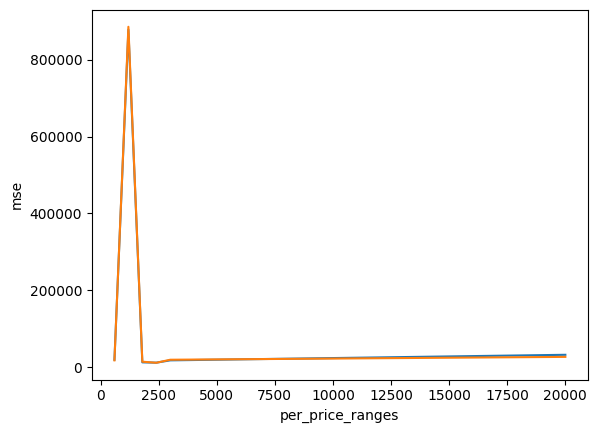

In [9]:
random_forest_line = plt.plot(segments[1:], random_forest_mses, label='random_forest')
gradient_boosting_line = plt.plot(segments[1:], gradient_boosting_mses, label='gradient_boosting')
plt.xlabel("per_price_ranges")
plt.ylabel("mse")
plt.show()